### Engineers' Salary Prediction Challenge

In [1]:
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

#### Wczytanie danych

In [2]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

train.head()

,obs,job_title,job_posted_date,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1,Others,2024/07,High,NY,A,0.6429,False,False,True,...,-0.362079,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340
1,2,Job_Title_1,2024/07,Low,CA,A,0.4678,False,False,False,...,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364
2,3,Others,2024/07,Low,CA,A,0.4610,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,Others,2024/07,Low,CA,A,0.5064,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,Others,2024/07,Low,CA,A,0.4640,False,False,False,...,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Columns: 317 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(5)
memory usage: 3.0+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Columns: 316 entries, obs to job_desc_300
dtypes: bool(9), float64(302), int64(1), object(4)
memory usage: 2.0+ MB


In [5]:
def compare_train_test(column):
    train_values = train[column].value_counts().reset_index(name='train_count')
    test_values = test[column].value_counts().reset_index(name='test_count')
    return pd.merge(test_values, train_values, how='outer', on=column)

c_job_title = compare_train_test('job_title')
c_job_state = compare_train_test('job_state')

### <center>Braki w kolumnach</center>

In [6]:
train.isnull().sum().sort_values(ascending=False)

feature_10         446
job_state           27
job_posted_date      1
obs                  0
job_desc_193         0
                  ... 
job_desc_091         0
job_desc_090         0
job_desc_089         0
job_desc_088         0
job_desc_300         0
Length: 317, dtype: int64

In [7]:
test.isnull().sum().sort_values(ascending=False)

feature_10      314
job_state        13
obs               0
job_desc_193      0
job_desc_200      0
               ... 
job_desc_091      0
job_desc_090      0
job_desc_089      0
job_desc_088      0
job_desc_300      0
Length: 316, dtype: int64

### <center>Analiza kolumn job_desc</center>

In [8]:
job_desc_cols = [col for col in train.columns if col.startswith('job_desc_')]

train['is_description'] = (train[job_desc_cols].sum(axis=1) != 0).astype(int)
test['is_description'] = (test[job_desc_cols].sum(axis=1) != 0).astype(int)

### <center>Miesiąc i rok</center>

In [9]:
train['job_posted_date'] = pd.to_datetime(train['job_posted_date'], format='%Y/%m')
train['month'] = train['job_posted_date'].dt.month
train['year'] = train['job_posted_date'].dt.year
train.drop(columns=['job_posted_date'], inplace=True)

test['job_posted_date'] = pd.to_datetime(test['job_posted_date'], format='%Y/%m')
test['month'] = test['job_posted_date'].dt.month
test['year'] = test['job_posted_date'].dt.year
test.drop(columns=['job_posted_date'], inplace=True)

### <center>Porównanie wybranych kolumn kategorycznych w train/test</center>

#### <center>Stan w którym jest oferta pracy "job_state"</center>

In [10]:
c_job_state

,job_state,test_count,train_count
0,AK,NaN,1.0
1,AL,1.0,1.0
2,AR,1.0,1.0
3,AZ,2.0,2.0
4,CA,391.0,559.0
5,CO,4.0,8.0
6,CT,8.0,2.0
7,DC,4.0,8.0
8,FL,1.0,6.0
9,GA,4.0,10.0


#### Zmiana stanów na regiony USA

In [11]:
west_states = [
    'AK', 'AZ', 'CA', 'CO', 'HI', 'ID',
    'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY'
]

central_states = [
    'AR', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA',
    'MI', 'MN', 'MO', 'ND', 'NE', 'OH',
    'OK', 'SD', 'TX', 'WI'
]

east_states = [
    'AL', 'CT', 'DE', 'FL', 'GA', 'MA', 'MD',
    'ME', 'MS', 'NC', 'NH', 'NJ', 'NY', 'PA',
    'RI', 'SC', 'TN', 'VA', 'VT', 'WV', 'DC'
]

def map_state_to_region(state):
    if state in west_states:
        return 'West'
    elif state in central_states:
        return 'Central'
    elif state in east_states:
        return 'East'
    else:
        return 'Other'

train['job_region'] = train['job_state'].apply(map_state_to_region)
test['job_region'] = test['job_state'].apply(map_state_to_region)

#### <center>WYKRES: Stan USA, a wysokość pensji</center>

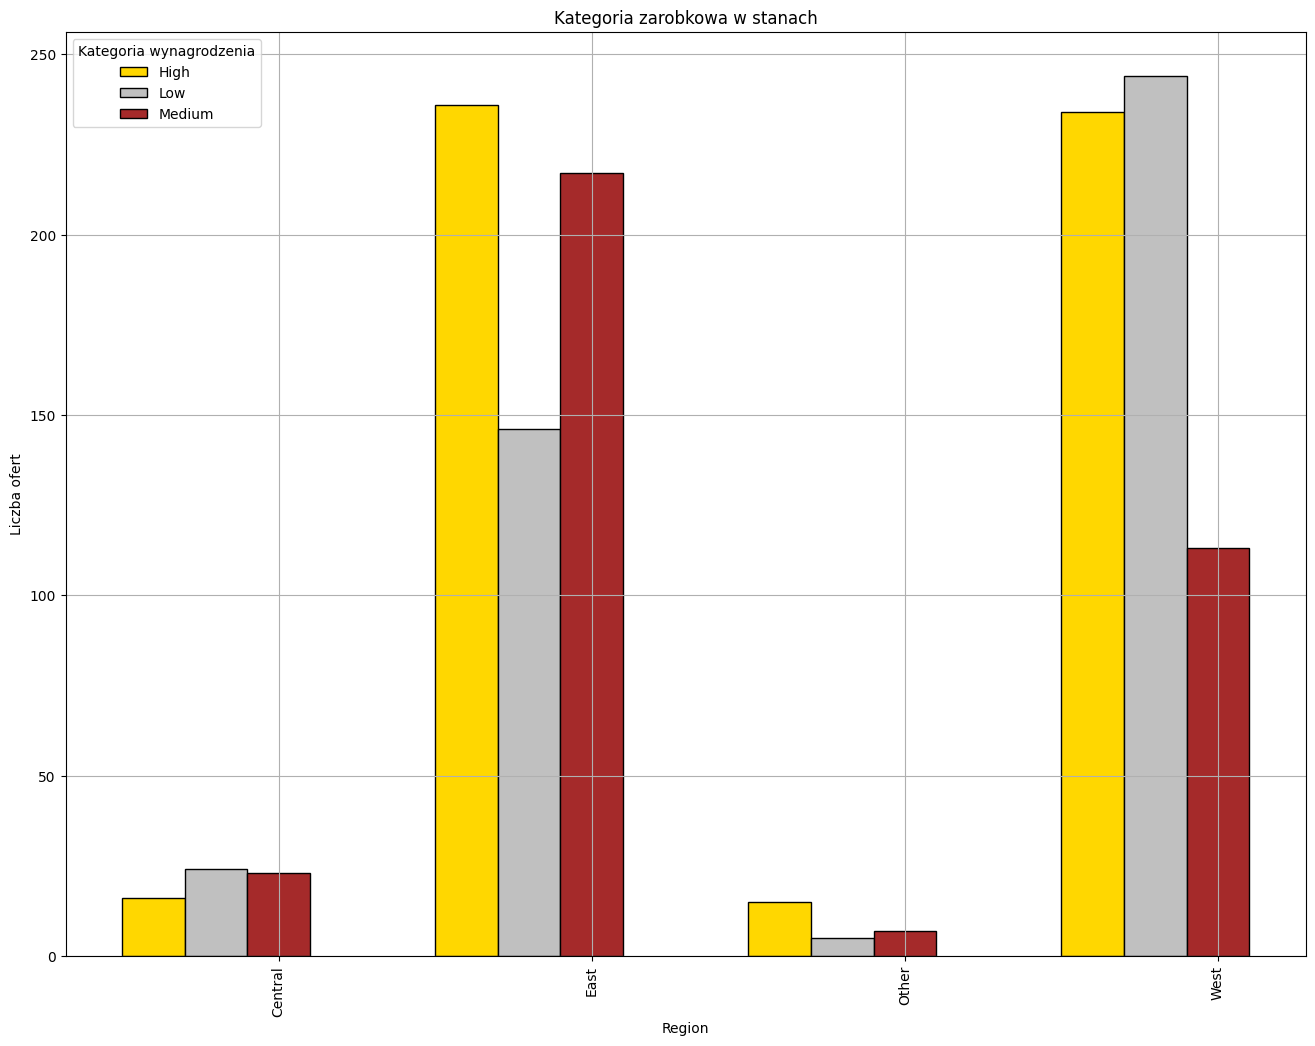

In [12]:
salary_types = train['salary_category'].unique()

show_every_region = train.groupby(['job_region', 'salary_category']).size().unstack(fill_value=0).reindex(columns=salary_types, fill_value=0).stack().reset_index(name='Count')

width = 0.2
x = np.arange(len(show_every_region['job_region'].unique()))
my_xticks = [x - width, x, x + width]
colors = ['gold', 'silver', 'brown']

fig, ax = plt.subplots(figsize=(16, 12))

for i, salary in enumerate(salary_types):
    ax.bar(
        x=my_xticks[i],
        height=show_every_region.loc[(show_every_region['salary_category'] == salary), 'Count'],
        width=width,
        label=salary,
        color=colors[i],
        edgecolor='black',
        alpha=1,
    )

ax.grid(True)
ax.set_xticks(x + width)
ax.set_xticklabels(show_every_region['job_region'].unique(), rotation=90)
ax.set_xlabel('Region')
ax.set_ylabel('Liczba ofert')
ax.set_title('Kategoria zarobkowa w stanach')
ax.legend(title='Kategoria wynagrodzenia')

#### Kodowanie one-hot "job_region"

In [13]:
job_region_one_hot = OneHotEncoder(sparse_output=False)
job_region_one_hot.fit(train[['job_region']])

train = pd.concat([train, pd.DataFrame(job_region_one_hot.transform(train[['job_region']]), columns=job_region_one_hot.categories_[0])], axis=1)
test = pd.concat([test, pd.DataFrame(job_region_one_hot.transform(test[['job_region']]), columns=job_region_one_hot.categories_[0])], axis=1)

train.drop(columns=['job_state', 'job_region'], inplace=True)
test.drop(columns=['job_state', 'job_region'], inplace=True)

#### <center>Stanowisko pracy "job_title"</center>

In [14]:
c_job_title

,job_title,test_count,train_count
0,Job_Title_1,13,27
1,Job_Title_10,46,53
2,Job_Title_11,1,9
3,Job_Title_12,7,7
4,Job_Title_13,13,11
5,Job_Title_14,2,3
6,Job_Title_15,2,4
7,Job_Title_16,3,6
8,Job_Title_17,3,4
9,Job_Title_18,1,4


#### <center>WYKRES: Stanowisko pracy a wysokość pensji</center>

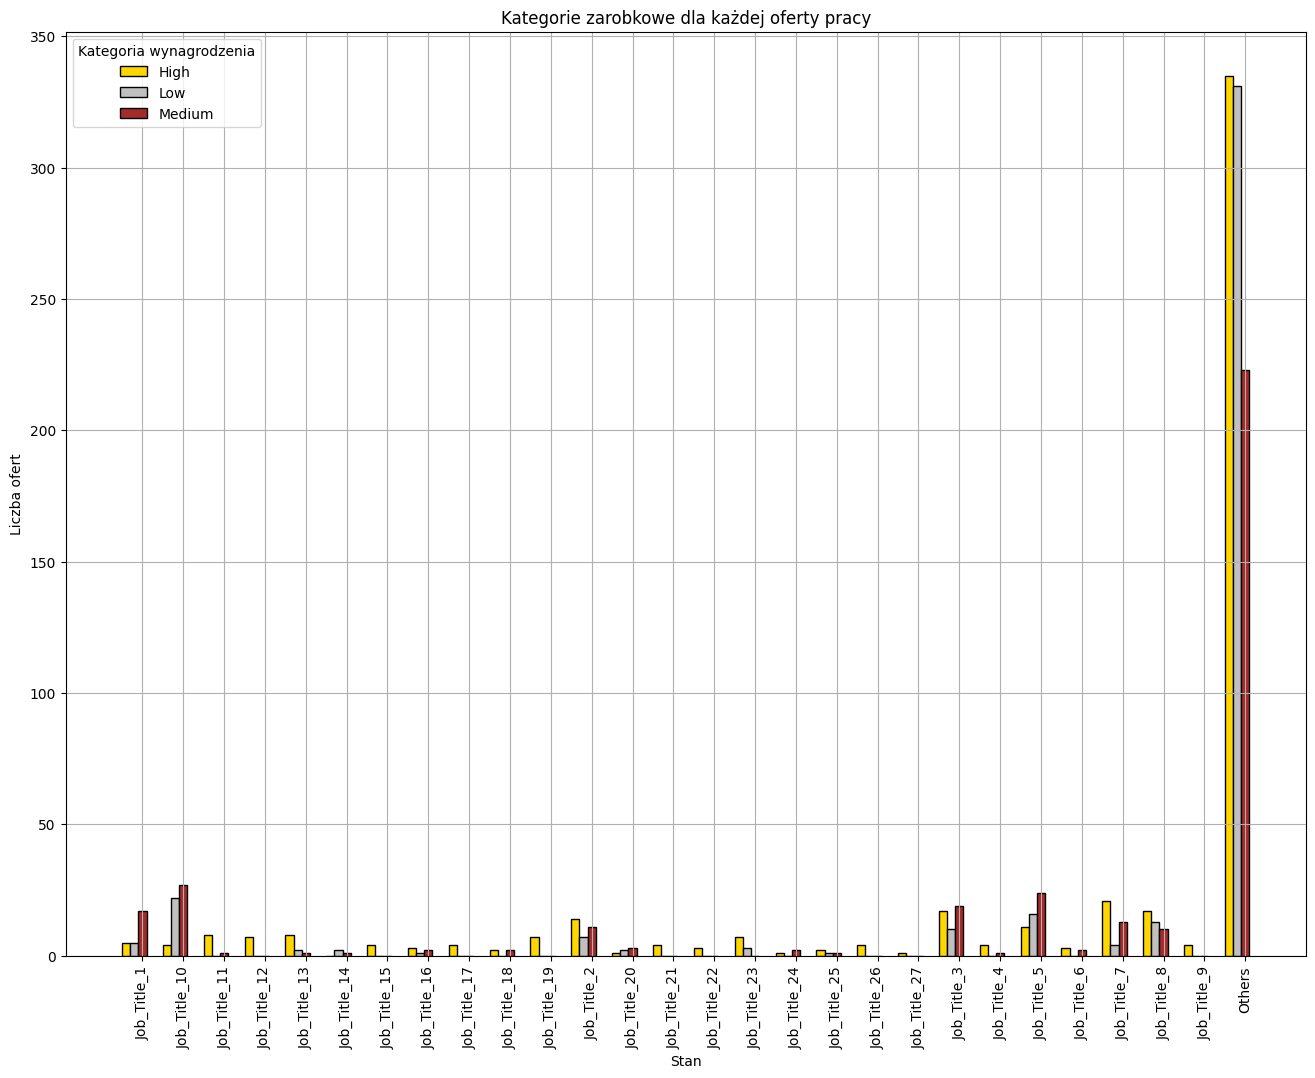

In [15]:
salary_types = train['salary_category'].unique()

show_every_state = train.groupby(['job_title', 'salary_category']).size().unstack(fill_value=0).reindex(columns=salary_types, fill_value=0).stack().reset_index(name='Count')

width = 0.2
x = np.arange(len(show_every_state['job_title'].unique()))
my_xticks = [x - width, x, x + width]
colors = ['gold', 'silver', 'brown']

fig, ax = plt.subplots(figsize=(16, 12))

for i, salary in enumerate(salary_types):
    ax.bar(
        x=my_xticks[i],
        height=show_every_state.loc[(show_every_state['salary_category'] == salary), 'Count'],
        width=width,
        label=salary,
        color=colors[i],
        edgecolor='black',
        alpha=1,
    )

ax.grid(True)
ax.set_xticks(x + width)
ax.set_xticklabels(show_every_state['job_title'].unique(), rotation=90)
ax.set_xlabel('Stan')
ax.set_ylabel('Liczba ofert')
ax.set_title('Kategorie zarobkowe dla każdej oferty pracy')
ax.legend(title='Kategoria wynagrodzenia')

#### Kodowanie one-hot "job_title"

In [16]:
job_title_one_hot = OneHotEncoder(sparse_output=False)
job_title_one_hot.fit(train[['job_title']])

train = pd.concat([train, pd.DataFrame(job_title_one_hot.transform(train[['job_title']]), columns=job_title_one_hot.categories_[0])], axis=1)
test = pd.concat([test, pd.DataFrame(job_title_one_hot.transform(test[['job_title']]), columns=job_title_one_hot.categories_[0])], axis=1)

train.drop(columns=['job_title'], inplace=True)
test.drop(columns=['job_title'], inplace=True)

#### <center>Kolumny "feature_"</center>

In [17]:
feature_columns = [col for col in train.columns if col.startswith('feature_')]

train[feature_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_1   1280 non-null   object 
 1   feature_2   1280 non-null   float64
 2   feature_3   1280 non-null   bool   
 3   feature_4   1280 non-null   bool   
 4   feature_5   1280 non-null   bool   
 5   feature_6   1280 non-null   bool   
 6   feature_7   1280 non-null   bool   
 7   feature_8   1280 non-null   bool   
 8   feature_9   1280 non-null   bool   
 9   feature_10  834 non-null    float64
 10  feature_11  1280 non-null   bool   
 11  feature_12  1280 non-null   bool   
dtypes: bool(9), float64(2), object(1)
memory usage: 41.4+ KB


In [18]:
grouped_feature_1 = train.groupby(['salary_category', 'feature_1']).size().unstack(fill_value=0)

feature_1_encoder = LabelEncoder().fit(train['feature_1'])
train['feature_1'] = feature_1_encoder.transform(train['feature_1'])
test['feature_1'] = feature_1_encoder.transform(test['feature_1'])

grouped_feature_1

feature_1,A,B,C,D,E
salary_category,,,,,
High,500,0,0,1,0
Low,373,36,6,3,1
Medium,359,0,0,1,0


W feature_10 okres 06-08/2024 ma najwięcej brakujących wartości dla zbioru treningowego.

Tak samo jest w zbiorze testowym.

In [19]:
train_grouped_feature_10 = train.loc[train['feature_10'].isna(), ['month', 'year']]

train_grouped_feature_10.groupby(['year', 'month']).size().sort_values(ascending=False).head(n=3)

year    month
2024.0  7.0      184
        8.0       60
        6.0       29
dtype: int64

In [20]:
test_grouped_feature_10 = test.loc[test['feature_10'].isna(), ['month', 'year']]

test_grouped_feature_10.groupby(['year', 'month']).size().sort_values(ascending=False).head(n=3)

year  month
2024  7        136
      8         28
      6         28
dtype: int64

#### Kodowanie LabelEncoder na salary_category

In [21]:
salary_category = train['salary_category']
salary_category_encoder = LabelEncoder().fit(salary_category)
train['salary_category'] = salary_category_encoder.transform(train['salary_category'])

#### Wartości korelacji dla kolumny salary_category

In [22]:
train.drop(columns=['obs'], inplace=True)
test_obs = test['obs']
test.drop(columns=['obs'], inplace=True)

corr = train.corr()[['salary_category']]

columns_to_drop = corr.loc[(corr['salary_category'] < 0.02) & (corr['salary_category'] > -0.02), :].index.values

train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Columns: 294 entries, salary_category to Others
dtypes: bool(8), float64(283), int32(3)
memory usage: 2.8 MB


### <center>Proces nauki, walidacji, testowania</center>

#### LightGBM

In [24]:
X = train.drop(columns=['salary_category'])
y = salary_category_encoder.transform(salary_category)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [25]:
lgb_model = lgb.LGBMClassifier().fit(X, y)

print(classification_report(y_test, lgb_model.predict(X_test), target_names=salary_category_encoder.inverse_transform(np.unique(y_train))))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65094
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 276
[LightGBM] [Info] Start training from score -0.938009
[LightGBM] [Info] Start training from score -1.116744
[LightGBM] [Info] Start training from score -1.268511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        94
         Low       1.00      1.00      1.00        85
      Medium       1.00      1.00      1.00        77

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



#### Istotność cech dla LightGBM

In [26]:
importance = pd.DataFrame(data={'names': lgb_model.feature_name_, 'importance': lgb_model.feature_importances_}).sort_values(by='importance', ascending=False)

importance

,names,importance
1,feature_2,993
266,month,375
8,feature_10,356
292,Others,150
0,feature_1,94
...,...,...
276,Job_Title_14,0
275,Job_Title_13,0
274,Job_Title_12,0
273,Job_Title_11,0


#### Las losowy

In [27]:
random_forest = RandomForestClassifier().fit(X, y)

print(classification_report(y_test, random_forest.predict(X_test), target_names=salary_category_encoder.inverse_transform(np.unique(y_train))))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        94
         Low       1.00      1.00      1.00        85
      Medium       1.00      1.00      1.00        77

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



#### Istotność cech dla lasu losowego

In [28]:
random_forest_importance = pd.DataFrame(data={'feature': random_forest.feature_names_in_, 'importance': random_forest.feature_importances_}).sort_values(by='importance', ascending=False)

random_forest_importance

,feature,importance
1,feature_2,0.076221
266,month,0.019045
8,feature_10,0.016223
6,feature_8,0.012298
243,job_desc_275,0.010017
...,...,...
281,Job_Title_21,0.000000
279,Job_Title_19,0.000000
278,Job_Title_17,0.000000
291,Job_Title_9,0.000000


#### Przygotowanie submission

In [29]:
rf_pred_proba = random_forest.predict_proba(X_test)
lgb_pred_proba = lgb_model.predict_proba(X_test)

avg = (rf_pred_proba + lgb_pred_proba) / 2

print(classification_report(y_test, np.argmax(avg, axis=1), target_names=salary_category_encoder.inverse_transform(np.unique(y_train))))

              precision    recall  f1-score   support

        High       1.00      1.00      1.00        94
         Low       1.00      1.00      1.00        85
      Medium       1.00      1.00      1.00        77

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



In [30]:
final_rf_pred = random_forest.predict(test)
final_lgb_pred = lgb_model.predict(test)
final_rf_pred_proba = random_forest.predict_proba(test)
final_lgb_pred_proba = lgb_model.predict_proba(test)

final_avg = (final_rf_pred_proba + final_lgb_pred_proba) / 2

final_avg

array([[0.97431765, 0.0101199 , 0.01556245],
       [0.63241473, 0.15138915, 0.21619613],
       [0.70419052, 0.17263661, 0.12317287],
       ...,
       [0.37424322, 0.35229995, 0.27345683],
       [0.08687777, 0.74521724, 0.16790499],
       [0.33061362, 0.17150188, 0.49788449]])

In [31]:
def prepare_submission(predictions, name):
    submission = pd.DataFrame(data={'obs': test_obs, 'salary_category': salary_category_encoder.inverse_transform(predictions)})
    submission.to_csv(os.path.join('submissions', f'{name}.csv'), index=False)

prepare_submission(final_rf_pred, 'random_forest')
prepare_submission(final_lgb_pred, 'lgb')
prepare_submission(np.argmax(final_avg, axis=1), 'average_lgb_random_forest')

### Informacje o modelach

In [39]:
with open(os.path.join('models', 'model_info.txt'), 'w') as f:
    f.write(f"Test size:\n{0.2}\n\n")

    f.write("Random Forest Parameters:\n")
    for key, value in random_forest.get_params().items():
        f.write(f"{key}: {value}\n")

    f.write("\nLightGBM Parameters:\n")
    for key, value in lgb_model.get_params().items():
        f.write(f"{key}: {value}\n")
